In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [212]:
# Carregar dados
df = pd.read_csv('usa_rain_prediction_dataset_2024_2025.csv')  # Substitua com o caminho correto
df.head()


,Date,Location,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow
0,2024-01-01,New York,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0
1,2024-01-02,New York,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0
2,2024-01-03,New York,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1
3,2024-01-04,New York,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0
4,2024-01-05,New York,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0


Temperature      408.274078
Humidity         532.045646
Wind Speed        75.146854
Precipitation      0.225466
Cloud Cover      675.089622
Pressure         408.197117
Rain Tomorrow      0.171832
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           73100 non-null  object 
 1   Location       73100 non-null  object 
 2   Temperature    73100 non-null  float64
 3   Humidity       73100 non-null  float64
 4   Wind Speed     73100 non-null  float64
 5   Precipitation  73100 non-null  float64
 6   Cloud Cover    73100 non-null  float64
 7   Pressure       73100 non-null  float64
 8   Rain Tomorrow  73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB
None
        Temperature      Humidity    Wind Speed  Precipitation   Cloud Cover  \
count  73100.000000  73100.000000  73100.000000   

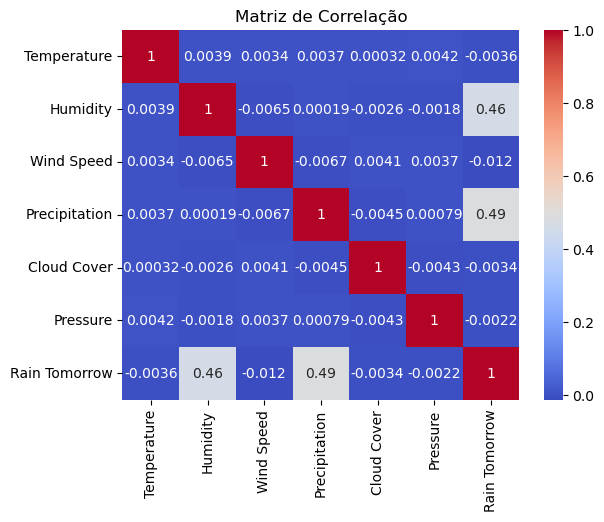

In [213]:
print(df.var(numeric_only=True))
print(df.info())
print(df.describe())
print(df.isnull().sum())

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


In [214]:
df["Temperature"] = np.log(df["Temperature"])
df["Humidity"] = np.log(df["Humidity"])
df["Wind Speed"] = np.log(df["Wind Speed"])
df["Cloud Cover"] = np.log(df["Cloud Cover"])
df["Pressure"] = np.log(df["Pressure"])
print(df.head())


         Date  Location  Temperature  Humidity  Wind Speed  Precipitation  \
0  2024-01-01  New York     4.471922  4.326190    3.345667       0.000000   
1  2024-01-02  New York     4.421960  3.357337    2.520630       0.526995   
2  2024-01-03  New York     4.393746  4.170380    2.652173       0.916884   
3  2024-01-04  New York     4.357959  4.089985    2.967540       0.094134   
4  2024-01-05  New York     3.612537  3.548662    1.305534       1.361272   

   Cloud Cover  Pressure  Rain Tomorrow  
0     4.243023  6.933453              0  
1     3.728246  6.903709              0  
2     4.348531  6.888365              1  
3     3.961598  6.886544              0  
4     4.449498  6.939051              0  


In [215]:
df['Date'] = pd.to_datetime(df['Date'])

def get_season(date):
    month = date.month
    day = date.day

    if (month == 3 and day >= 20) or (month == 4) or (month==5) or (month==6 and day < 21):
        return 'Primavera'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 23):
        return 'Verão'
    elif (month == 9 and day >= 23) or (month == 10) or (month == 11) or (month == 12 and day < 21):
        return 'Outuno'
    else:
        return 'Inveno'

df["Estacao"] = df["Date"].apply(get_season)

encoder = OneHotEncoder(sparse_output=False)
estacao_encoded = encoder.fit_transform(df[["Estacao"]])
estacao_df = pd.DataFrame(estacao_encoded, columns=encoder.get_feature_names_out(["Estacao"]))
df = pd.concat([df, estacao_df], axis=1)

print(df.head())

        Date  Location  Temperature  Humidity  Wind Speed  Precipitation  \
0 2024-01-01  New York     4.471922  4.326190    3.345667       0.000000   
1 2024-01-02  New York     4.421960  3.357337    2.520630       0.526995   
2 2024-01-03  New York     4.393746  4.170380    2.652173       0.916884   
3 2024-01-04  New York     4.357959  4.089985    2.967540       0.094134   
4 2024-01-05  New York     3.612537  3.548662    1.305534       1.361272   

   Cloud Cover  Pressure  Rain Tomorrow Estacao  Estacao_Inveno  \
0     4.243023  6.933453              0  Inveno             1.0   
1     3.728246  6.903709              0  Inveno             1.0   
2     4.348531  6.888365              1  Inveno             1.0   
3     3.961598  6.886544              0  Inveno             1.0   
4     4.449498  6.939051              0  Inveno             1.0   

   Estacao_Outuno  Estacao_Primavera  Estacao_Verão  
0             0.0                0.0            0.0  
1             0.0               

In [216]:
# Mapeamento completo de cidades para estados
cidade_para_estado = {
    'Los Angeles': 'California',
    'Chicago': 'Illinois',
    'Houston': 'Texas',
    'Phoenix': 'Arizona',
    'Philadelphia': 'Pennsylvania',
    'San Antonio': 'Texas',
    'San Diego': 'California',
    'Dallas': 'Texas',
    'San Jose': 'California',
    'Austin': 'Texas',
    'Jacksonville': 'Florida',
    'Fort Worth': 'Texas',
    'Columbus': 'Ohio',
    'Indianapolis': 'Indiana',
    'Charlotte': 'North Carolina',
    'San Francisco': 'California',
    'Seattle': 'Washington',
    'Denver': 'Colorado',
    'New York': 'New York',
    'Washington D.C.': 'District of Columbia'
}

estado_para_regiao = {
    'California': 'Oeste',
    'Illinois': 'Meio-Oeste',
    'Texas': 'Sul',
    'Arizona': 'Oeste',
    'Pennsylvania': 'Nordeste',
    'Florida': 'Sul',
    'Ohio': 'Meio-Oeste',
    'Indiana': 'Meio-Oeste',
    'North Carolina': 'Sul',
    'Washington': 'Oeste',
    'Colorado': 'Oeste',
    'New York': 'Nordeste',
    'District of Columbia': 'Sul'
}

def cidade_para_regiao(cidade):
    cidade = cidade.title()
    estado = cidade_para_estado.get(cidade)
    if estado:
        return estado_para_regiao.get(estado)
    return None

# df['Estado'] = df['Location'].map(cidade_para_estado)
df['Region'] = df['Location'].apply(cidade_para_regiao)

cidades_nao_mapeadas = df[df['Region'].isna()]['Location'].unique()
if len(cidades_nao_mapeadas) > 0:
    print(f"\nCidades não mapeadas: {cidades_nao_mapeadas}")
else:
    print("\nTodas as cidades foram mapeadas com sucesso!")

encoder = OneHotEncoder(sparse_output=False)
region_encoded = encoder.fit_transform(df[['Region']])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))
df = pd.concat([df, region_df], axis=1)

print(f"Region Nan sum: {df["Region"].isna().sum()}")
print(df.head())



Todas as cidades foram mapeadas com sucesso!
Region Nan sum: 0
        Date  Location  Temperature  Humidity  Wind Speed  Precipitation  \
0 2024-01-01  New York     4.471922  4.326190    3.345667       0.000000   
1 2024-01-02  New York     4.421960  3.357337    2.520630       0.526995   
2 2024-01-03  New York     4.393746  4.170380    2.652173       0.916884   
3 2024-01-04  New York     4.357959  4.089985    2.967540       0.094134   
4 2024-01-05  New York     3.612537  3.548662    1.305534       1.361272   

   Cloud Cover  Pressure  Rain Tomorrow Estacao  Estacao_Inveno  \
0     4.243023  6.933453              0  Inveno             1.0   
1     3.728246  6.903709              0  Inveno             1.0   
2     4.348531  6.888365              1  Inveno             1.0   
3     3.961598  6.886544              0  Inveno             1.0   
4     4.449498  6.939051              0  Inveno             1.0   

   Estacao_Outuno  Estacao_Primavera  Estacao_Verão    Region  \
0          

In [217]:
df = df.drop(['Date', 'Location', 'Estacao', 'Region'], axis=1)

X = df.drop('Rain Tomorrow', axis=1)
y = df['Rain Tomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [218]:
def avaliar_modelos(X_train, X_test, y_train, y_test, scaled=False):
    modelos = {
        'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
        'Decision Tree': DecisionTreeClassifier(max_depth=5),
        'Random Forest': RandomForestClassifier()
    }

    resultados = []

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred_train = modelo.predict(X_train)
        y_pred_test = modelo.predict(X_test)

        resultados.append({
            'Modelo': nome + (' (Escalado)' if scaled else ''),
            'Accuracy Train': accuracy_score(y_train, y_pred_train),
            'Accuracy Test': accuracy_score(y_test, y_pred_test),
            'Precision Test': precision_score(y_test, y_pred_test),
            'Recall Test': recall_score(y_test, y_pred_test),
            'F1 Score Test': f1_score(y_test, y_pred_test)
        })

    return resultados


In [219]:
resultados_sem_scaler = avaliar_modelos(X_train, X_test, y_train, y_test)


In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

resultados_com_scaler = avaliar_modelos(X_train_scaled, X_test_scaled, y_train, y_test, scaled=True)


In [221]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for nome, modelo in {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier()
}.items():
    scores = cross_val_score(modelo, X, y, cv=kf, scoring='accuracy')
    print(f'{nome} - Média Accuracy (K-Fold): {scores.mean():.4f}')


Logistic Regression - Média Accuracy (K-Fold): 0.9181
Decision Tree - Média Accuracy (K-Fold): 1.0000
Random Forest - Média Accuracy (K-Fold): 1.0000


In [222]:
df_resultados = pd.DataFrame(resultados_sem_scaler + resultados_com_scaler)
df_resultados


,Modelo,Accuracy Train,Accuracy Test,Precision Test,Recall Test,F1 Score Test
0,Logistic Regression,0.916826,0.922914,0.883671,0.752384,0.812760
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
2,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression (Escalado),0.916758,0.922503,0.882035,0.752076,0.811888
4,Decision Tree (Escalado),1.000000,1.000000,1.000000,1.000000,1.000000
5,Random Forest (Escalado),1.000000,1.000000,1.000000,1.000000,1.000000


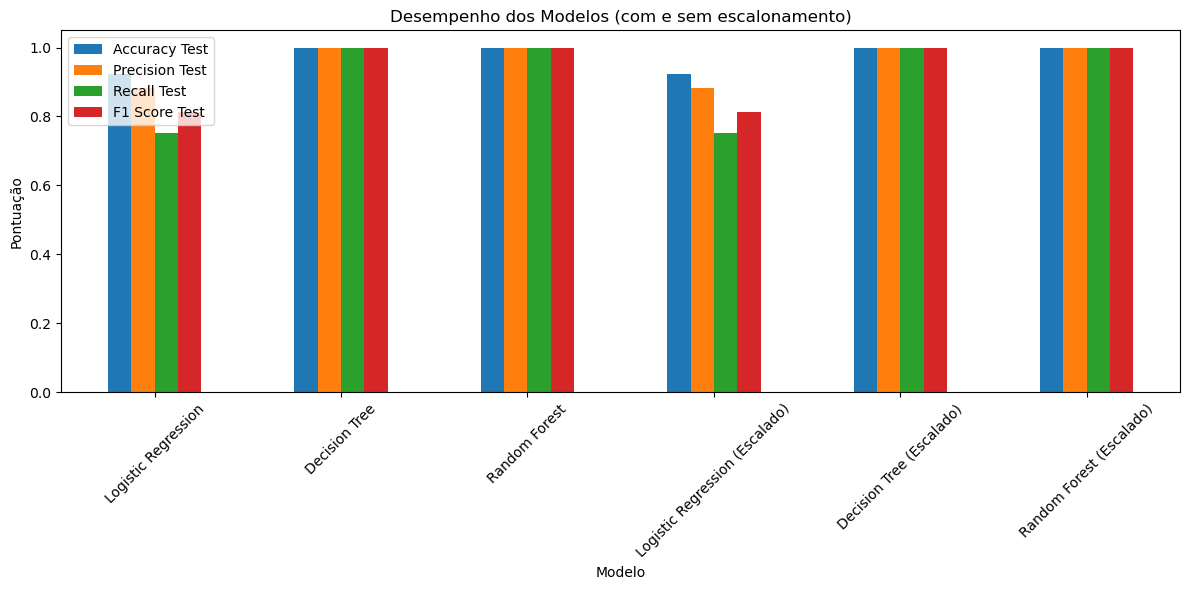

In [223]:
fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_resultados.set_index('Modelo')[['Accuracy Test', 'Precision Test', 'Recall Test', 'F1 Score Test']]
df_plot.plot(kind='bar', ax=ax)
plt.title('Desempenho dos Modelos (com e sem escalonamento)')
plt.ylabel('Pontuação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
